# 케라스 Word2Vec 구현

* 참고: https://wikidocs.net/69141

### 전처리

In [6]:
from sklearn.datasets import fetch_20newsgroups

dataset = fetch_20newsgroups(shuffle = True, random_state = 1,
                             remove = ('headers', 'footers', 'quotes'))

documents = dataset.data

print(len(documents))
documents[1]

11314


"\n\n\n\n\n\n\nYeah, do you expect people to read the FAQ, etc. and actually accept hard\natheism?  No, you need a little leap of faith, Jimmy.  Your logic runs out\nof steam!\n\n\n\n\n\n\n\nJim,\n\nSorry I can't pity you, Jim.  And I'm sorry that you have these feelings of\ndenial about the faith you need to get by.  Oh well, just pretend that it will\nall end happily ever after anyway.  Maybe if you start a new newsgroup,\nalt.atheist.hard, you won't be bummin' so much?\n\n\n\n\n\n\nBye-Bye, Big Jim.  Don't forget your Flintstone's Chewables!  :) \n--\nBake Timmons, III"

In [12]:
import re
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

def clean_text(d):
    pattern = r'[^a-zA-z\s]'
    text = re.sub(pattern, '', d)
    return text

def clean_stopword(d):
    stop_words = stopwords.words('english')
    return ' '.join([w.lower() for w in d.split() if w.lower() not in stop_words and len(w) > 3])

def tokenize(d):
    return word_tokenize(d)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
import pandas as pd

news_df = pd.DataFrame({'article':documents})
print(len(news_df))

11314


In [14]:
news_df.replace("", float("NaN"), inplace = True)
news_df.dropna(inplace = True)
print(len(news_df))

11096


In [15]:
news_df['article'] = news_df['article'].apply(clean_text)
news_df['article']

0        Well im not sure about the story nad it did se...
1        \n\n\n\n\n\n\nYeah do you expect people to rea...
2        Although I realize that principle is not one o...
3        Notwithstanding all the legitimate fuss about ...
4        Well I will have to change the scoring on my p...
                               ...                        
11309    Danny Rubenstein an Israeli journalist will be...
11310                                                   \n
11311    \nI agree  Home runs off Clemens are always me...
11312    I used HP DeskJet with Orange Micros Grappler ...
11313                                          ^^^^^^\n...
Name: article, Length: 11096, dtype: object

In [16]:
news_df['article'] = news_df['article'].apply(clean_stopword)
news_df['article']

0        well sure story seem biased disagree statement...
1        yeah expect people read actually accept hard a...
2        although realize principle strongest points wo...
3        notwithstanding legitimate fuss proposal much ...
4        well change scoring playoff pool unfortunately...
                               ...                        
11309    danny rubenstein israeli journalist speaking t...
11310                                                     
11311    agree home runs clemens always memorable kinda...
11312    used deskjet orange micros grappler system upd...
11313    ^^^^^^ argument murphy scared hell came last y...
Name: article, Length: 11096, dtype: object

In [17]:
tokenized_news = news_df['article'].apply(tokenize)
tokenized_news = tokenized_news.to_list()

In [18]:
import numpy as np

drop_news = [index for index, sentence in enumerate(tokenized_news) if len(sentence) <= 1]
news_texts = np.delete(tokenized_news, drop_news, axis = 0)
print(len(news_texts))

10940


/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer

news_2000 = news_texts[:2000]

tokenizer = Tokenizer() # Tokenizer 인스턴스 생성
tokenizer.fit_on_texts(news_2000) # fit_on_texts : 문자 데이터를 입력받아서 리스트의 형태로 변환

idx2word = {value:key for key, value in tokenizer.word_index.items()} # word_index : 단어와 인덱스의 키-값 쌍을 포함하는 딕셔너리를 반환 / 키와 밸류를 반대로 받아옴
sequences = tokenizer.texts_to_sequences(news_2000) #  texts_to_sequences : text 문장을 단어에 대한 인덱스로 이루어진 리스트로 만듬

In [20]:
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size) # 단어수

31867


In [21]:
print(sequences[1])

[1238, 448, 4, 59, 116, 410, 62, 1348, 22, 68, 3482, 389, 6879, 1147, 365, 2228, 449, 58, 12618, 449, 1869, 3830, 389, 22, 11, 4313, 8777, 174, 296, 133, 151, 653, 12619, 318, 12620, 16, 12621, 6, 775, 12622, 12623, 4906, 8778]


### Skipgram

#### Skipgram 전처리

* 네거티브 샘플링(Negative Sampling)

  + Word2Vec은 출력층이 내놓는 값에 소프트맥스 함수를 적용해 확률값으로 변환한 후 이를 정답과 비교해 역전파(backpropagation)
  + 소프트맥스를 적용하려면 분모에 해당하는 값, 즉 중심단어와 나머지 모든 단어의 내적을 한 뒤, 이를 다시 exp 계산을 하는데 전체 단어가 많을 경우 엄청난 계산량 발생
  + 네거티브 샘플링은 소프트맥스 확률을 구할 때 전체 단어를 대상으로 구하지 않고, 일부 단어만 뽑아서 계산을 하는 방식
  + 네거티브 샘플링 동작은 사용자가 지정한 윈도우 사이즈 내에 등장하지 않는 단어(negative sample)를 5~20개 정도 뽑고, 이를 정답단어와 합쳐 전체 단어처럼 소프트맥스 확률을 계산하여 파라미터 업데이트

In [22]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# 샘플 10개만
skip_grams = [skipgrams(sample, vocabulary_size = vocab_size, window_size = 10) for sample in sequences[:10]]



- keras의 skipgrams : 단어 인덱스로 이루어진 리스트를 입력받아 중심 단어와 주변 단어의 쌍으로 이루어진 학습용 데이터 튜플을 생성
    - 리스트0: 문장 내의 중심 단어와 주변 단어로 이루어진 리스트들의 리스트. 중심 단어의 인덱스를 i, windows_size인자에서 지정한 '창의 크기'를 n이라고 하면 [i-n], [i-n+1], ..., [i-1], [i+1], ..., [i+n-1], [i+n]인덱스의 단어들이 각각 중심 단어 [i]와 단어 쌍을 만들게 됩니다. 따라서 각 중심 단어마다 2n개의 단어쌍을 만들며, 해당 중심 단어가 문장의 시작 또는 끝에 가까워서 어느 한쪽의 주변 단어 개수가 n보다 작을 경우 그 방향에 존재하는 주변 단어의 개수만큼 단어쌍이 생성됩니다. 또한 negative_samples 인자에서 지정한 비율에 따라 중심 단어와 '가짜 주변 단어'로 이루어진 '거짓 표본' 리스트들이 함께 생성됩니다.
    - 리스트1: 리스트0에 포함된 각 단어쌍이 실제 중심 단어와 주변 단어로 이루어진 '참 표본'인지, 무작위로 선택한 가짜 주변 단어로 이루어진 '거짓 표본'인지를 나타내는 레이블의 리스트입니다. 참인 경우 1, 거짓인 경우 0값을 갖습니다.
    - (출처 : https://github.com/keras-team/keras-docs-ko/blob/master/sources/preprocessing/sequence.md)

In [23]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

for i in range(5):
    print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
        idx2word[pairs[i][0]], pairs[i][0],  # 단어 쌍
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]))

makes(204), inhuman(8775) -> 1
israeli(685), inhuman(8775) -> 1
degree(1403), proofing(31714) -> 0
lived(985), media(488) -> 1
sure(63), jkpcshutfi(23249) -> 0


In [44]:
print(pairs)
print(labels)

[[204, 8775], [685, 8775], [1403, 31714], [985, 488], [63, 23249], [302, 3829], [2722, 11040], [11, 19738], [3197, 4904], [71, 21695], [942, 3480], [12615, 652], [1401, 6409], [8776, 4739], [2722, 13910], [48, 61], [63, 438], [2923, 488], [652, 23881], [379, 71], [3196, 23758], [985, 27287], [488, 5203], [488, 652], [8776, 5720], [71, 186], [123, 1237], [1284, 23307], [71, 29113], [985, 21169], [2923, 438], [8773, 25998], [1403, 6301], [488, 30693], [1284, 4904], [8773, 17826], [4905, 5026], [3480, 18686], [111, 22642], [986, 29987], [8, 39], [438, 12616], [4312, 3882], [1403, 13238], [6878, 71], [438, 3480], [111, 2722], [3196, 15385], [438, 500], [48, 4905], [3829, 204], [8, 170], [1401, 12615], [488, 10952], [3197, 10526], [1284, 1612], [8, 111], [3480, 6527], [12614, 2716], [39, 26356], [570, 39], [198, 23322], [488, 9607], [71, 2535], [3481, 14101], [1403, 8], [1402, 488], [3481, 23370], [652, 1402], [616, 1403], [12615, 500], [488, 2722], [652, 1800], [39, 4904], [488, 5719], [19

In [24]:
print(len(skip_grams))
print(len(pairs))
print(len(labels))

10
2220
2220


In [42]:
# 전체
skip_grams = [skipgrams(seq, vocabulary_size = vocab_size, window_size = 10) for seq in sequences]

#### Skipgram 모델 구성

In [25]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input, Dot
from tensorflow.keras.utils import plot_model

In [26]:
embed_size = 50

In [55]:
def word2vec():
    target_inputs = Input(shape = (1, ), dtype = 'int32') #  타겟 단어 1개
    target_embedding = Embedding(vocab_size, embed_size)(target_inputs)

    context_inputs = Input(shape = (1, ), dtype = 'int32') # 주변 단어 1개
    context_embedding = Embedding(vocab_size, embed_size)(context_inputs)

    dot_product = Dot(axes = 2)([target_embedding, context_embedding])
    dot_product = Reshape((1,), input_shape = (1, 1))(dot_product)
    output = Activation('sigmoid')(dot_product)

    model = Model(inputs = [target_inputs, context_inputs], outputs = output)
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam')

    return model

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 1, 50)        1593350     ['input_7[0][0]']                
                                                                                                  
 embedding_7 (Embedding)        (None, 1, 50)        1593350     ['input_8[0][0]']                
                                                                                            

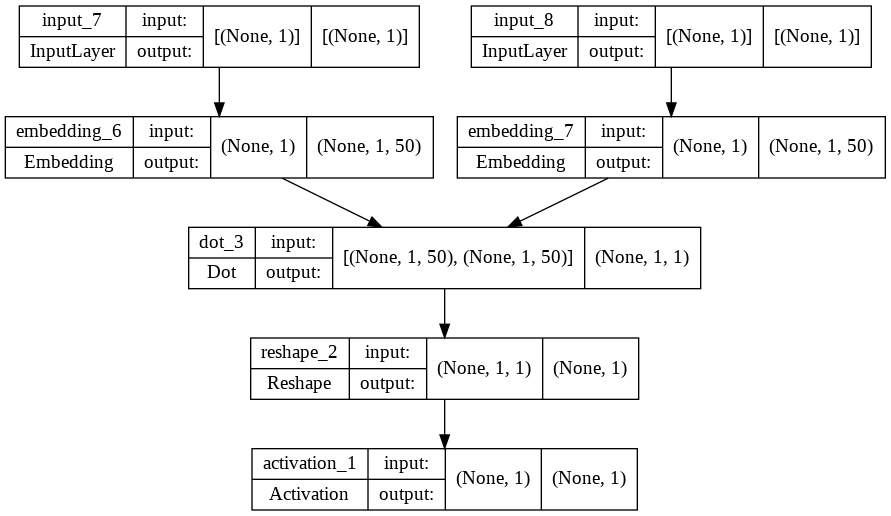

In [56]:
model = word2vec()
model.summary()
plot_model(model, show_shapes = True, show_layer_names = True)

In [58]:
for epoch in range(1, 11):
    loss = 0
    for _, elem in enumerate(skip_grams):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype = 'int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype = 'int32')
        labels = np.array(elem[1], dtype = 'int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X, Y)

    print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 1229.8148697465658
Epoch: 2 Loss: 919.8304151594639
Epoch: 3 Loss: 815.6505864262581
Epoch: 4 Loss: 766.4802672415972
Epoch: 5 Loss: 737.960433229804
Epoch: 6 Loss: 717.1058831252158
Epoch: 7 Loss: 697.2871895469725
Epoch: 8 Loss: 674.8487162999809
Epoch: 9 Loss: 648.0480330735445
Epoch: 10 Loss: 616.2853394504637


In [60]:
import gensim

f = open('skipgram.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))

f.close()

skipgram = gensim.models.KeyedVectors.load_word2vec_format('skipgram.txt', binary = False)

In [61]:
skipgram.most_similar(positive = ['soldier'])

[('traps', 0.858733057975769),
 ('booby', 0.856903612613678),
 ('ammunitions', 0.8155916333198547),
 ('sneak', 0.7774145603179932),
 ('indiscriminately', 0.7638734579086304),
 ('patrols', 0.7529697418212891),
 ('retalliates', 0.7455251812934875),
 ('aimed', 0.700111985206604),
 ('occupying', 0.6889836192131042),
 ('zone', 0.6447226405143738)]

In [62]:
skipgram.most_similar(positive = ['world'])

[('nightdresses', 0.6973046064376831),
 ('scalping', 0.672211766242981),
 ('democracy', 0.6670799255371094),
 ('disillusioned', 0.6464194655418396),
 ('humans', 0.6369016766548157),
 ('action', 0.632569432258606),
 ('civilized', 0.628735363483429),
 ('zubov', 0.6281915903091431),
 ('catching', 0.6196039915084839),
 ('grudgingly', 0.6173778176307678)]

### CBOW


#### CBOW 전처리

In [69]:
def skipgram2cbow(skipgrams):
    cbows = []
    flag = 0
    for n in skipgrams:
        temp1 = []
        for t in n:
            if flag == 1:
                flag = 0
                temp1.append(t)
            else:
                flag = 1
                temp2 = []
                for x in t:
                    temp2.append([x[1], x[0]])
                temp1.append(temp2)
        cbows.append(temp1)
    return cbows

In [70]:
cbows = skipgram2cbow(skip_grams)

In [71]:
pairs, labels = cbows[0][0], cbows[0][1]

for i in range(5):
    print("{:s}({:d}), {:s}({:d}) -> {:d}".format(
        idx2word[pairs[i][0]], pairs[i][0],  # 단어 쌍
        idx2word[pairs[i][1]], pairs[i][1],
        labels[i]))

europe(1611), media(488) -> 1
essential(4518), degree(1403) -> 0
scars(20919), media(488) -> 0
viewed(6257), existance(2722) -> 0
oeequivalent(21311), guilt(6878) -> 0


In [72]:
print(len(cbows))
print(len(pairs))
print(len(labels))

2000
2220
2220


#### CBOW 모델 구성

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 1, 50)        1593350     ['input_11[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, 1, 50)        1593350     ['input_12[0][0]']               
                                                                                            

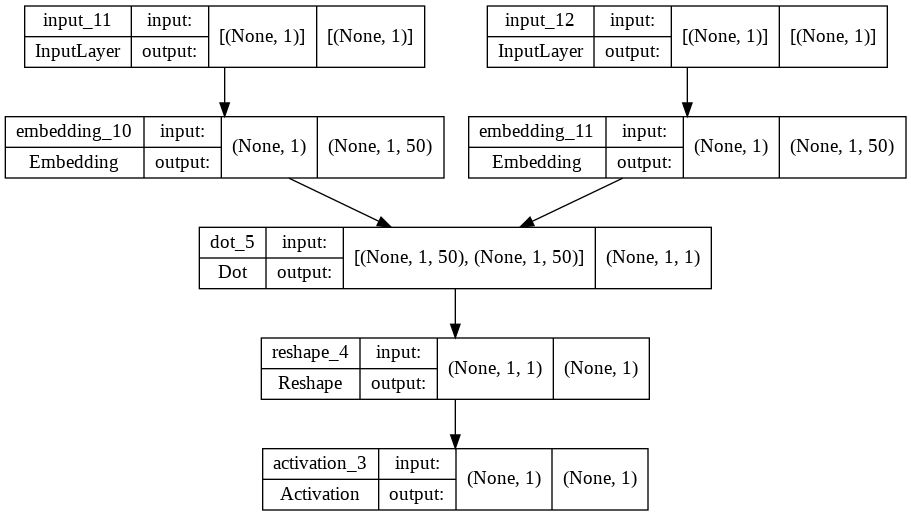

In [73]:
model = word2vec()
model.summary()
plot_model(model, show_shapes = True, show_layer_names = True)

In [74]:
for epoch in range(1, 11):
    loss = 0
    for _, elem in enumerate(cbows):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype = 'int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype = 'int32')
        labels = np.array(elem[1], dtype = 'int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X, Y)

    print('Epoch:', epoch, 'Loss:', loss)

Epoch: 1 Loss: 1226.8945797234774
Epoch: 2 Loss: 918.4782830402255
Epoch: 3 Loss: 815.4134475067258
Epoch: 4 Loss: 766.9454944804311
Epoch: 5 Loss: 738.955115288496
Epoch: 6 Loss: 718.3382126614451
Epoch: 7 Loss: 698.526885099709
Epoch: 8 Loss: 676.0163007974625
Epoch: 9 Loss: 649.1971390917897
Epoch: 10 Loss: 617.4861200451851


In [75]:
import gensim

f = open('cbow.txt', 'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))

f.close()

cbow = gensim.models.KeyedVectors.load_word2vec_format('cbow.txt', binary = False)

In [76]:
skipgram.most_similar(positive = ['soldier'])

[('traps', 0.858733057975769),
 ('booby', 0.856903612613678),
 ('ammunitions', 0.8155916333198547),
 ('sneak', 0.7774145603179932),
 ('indiscriminately', 0.7638734579086304),
 ('patrols', 0.7529697418212891),
 ('retalliates', 0.7455251812934875),
 ('aimed', 0.700111985206604),
 ('occupying', 0.6889836192131042),
 ('zone', 0.6447226405143738)]

In [77]:
skipgram.most_similar(positive = ['world'])

[('nightdresses', 0.6973046064376831),
 ('scalping', 0.672211766242981),
 ('democracy', 0.6670799255371094),
 ('disillusioned', 0.6464194655418396),
 ('humans', 0.6369016766548157),
 ('action', 0.632569432258606),
 ('civilized', 0.628735363483429),
 ('zubov', 0.6281915903091431),
 ('catching', 0.6196039915084839),
 ('grudgingly', 0.6173778176307678)]